# Libraries and modules imports

In [211]:
%load_ext autoreload
%autoreload 2

import torch 
print('Pytorch version :', torch.__version__)

from Class_PINN import PINN
from Class_CollocationPoints import CollocationPoints
from Class_ObservationPoints import ObservationPoints
from Backwater_model import J, compute_ref_solution
import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pytorch version : 2.1.2


# Cuda setup

In [212]:
# Device choice
use_GPU = False #Choose whether you want to use your GPU or not

if (torch.cuda.is_available() and use_GPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Running on {device} !')

#Additional info when using cuda
if (device.type == 'cuda'):
    print('GPU :', torch.cuda.get_device_name(0))
    print('Total memory :', 
          round(torch.cuda.get_device_properties(0).total_memory/1024**3, 1), 'GB')

#Set default usage to CPU or GPU
torch.set_default_device(device)

Running on cpu !


# $k_{true}$ definition

In [213]:
k_true = torch.tensor([45, 38, 28, 22, 30, 45, 60, 75]) #You can modify the value of k_true here !

# Collocation points definition

In [214]:
col = CollocationPoints(device, 
                        random = False, #Choose between grid collocation points (=True) and random collocation points (=False)
                        N_col = 100, #Choose number of collocation points
                        variable_boundaries = (0, 1000), #Choose the boundaries of the domain
                        test_size = 0, #Choose the testing set / training set ratio
                        seed = 0) #Set the seed to any integer number for reproductible randomness

# PINN definition

In [215]:
model = PINN(device, col = col,
             layers = [1, 40, 1], #Choose the neural network architecture
             k_0 = 40*torch.ones_like(k_true), #Choose the initialization value for k
             k_ref = 40, #Choose the reference value for scaling k
             k_interpolation = 'P1', #Choose the interpolation method for the k function (P1 or P0)
             seed = 0) #Set the seed to any integer number for reproductible randomness

# Reference solution and Observations generation

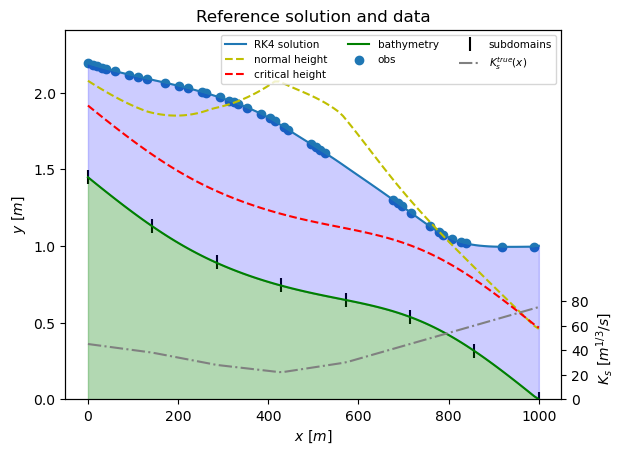

In [216]:
ref_solution = compute_ref_solution(model, col, k = k_true, dx = 10) 

obs = ObservationPoints(ref_solution, 
                        N_obs = 40, #Choose the number of observations in the domain
                        noise_std = 0, #Choose the standard deviation of the white noise added to the observations
                        seed = None) #Set the seed to any integer number for reproductible randomness

display.display_data(model, col, ref_solution, obs) 

# Model training 

##################################################
Processing iteration 50 (iter + eval = 67)
-------------------------
J           = 1.45e-04 (residual : 0.00e+00, BC : 1.44e-04, obs : 1.84e-07)
||grad(J)|| = 2.04e-02
parameter      = tensor([40., 40., 40., 40., 40., 40., 40., 40.])
time           = 0.34 s
##################################################
Processing iteration 100 (iter + eval = 126)
-------------------------
J           = 3.48e-05 (residual : 0.00e+00, BC : 3.45e-05, obs : 2.45e-07)
||grad(J)|| = 8.47e-04
parameter      = tensor([40., 40., 40., 40., 40., 40., 40., 40.])
time           = 0.66 s


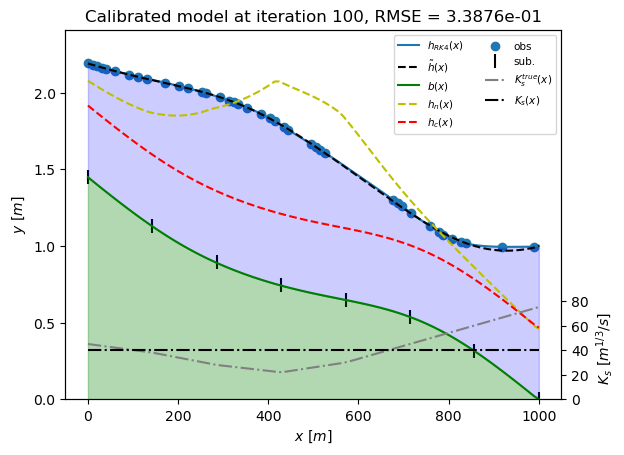

##################################################
Processing iteration 150 (iter + eval = 292)
-------------------------
J           = 3.49e-05 (residual : 1.05e-07, BC : 3.46e-05, obs : 1.93e-07)
||grad(J)|| = 9.53e-05
parameter      = tensor([45.2512, 38.1161, 28.2794, 21.4581, 28.7748, 46.4317, 58.9136, 51.3512])
time           = 1.50 s
##################################################
Processing iteration 200 (iter + eval = 408)
-------------------------
J           = 3.24e-05 (residual : 1.16e-07, BC : 3.19e-05, obs : 3.22e-07)
||grad(J)|| = 3.41e-05
parameter      = tensor([45.2512, 38.1161, 28.2794, 21.4582, 28.7748, 46.4317, 58.9135, 51.3512])
time           = 1.99 s


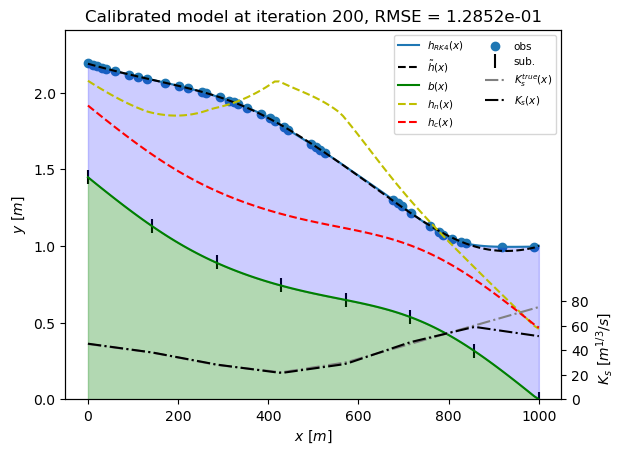

##################################################
Processing iteration 250 (iter + eval = 594)
-------------------------
J           = 3.24e-05 (residual : 1.16e-07, BC : 3.19e-05, obs : 3.28e-07)
||grad(J)|| = 7.14e-05
parameter      = tensor([45.2513, 38.1161, 28.2794, 21.4583, 28.7749, 46.4317, 58.9135, 51.3513])
time           = 3.07 s
##################################################
Processing iteration 300 (iter + eval = 740)
-------------------------
J           = 3.24e-05 (residual : 1.16e-07, BC : 3.19e-05, obs : 3.21e-07)
||grad(J)|| = 3.22e-05
parameter      = tensor([45.2513, 38.1161, 28.2794, 21.4585, 28.7749, 46.4317, 58.9134, 51.3514])
time           = 3.71 s


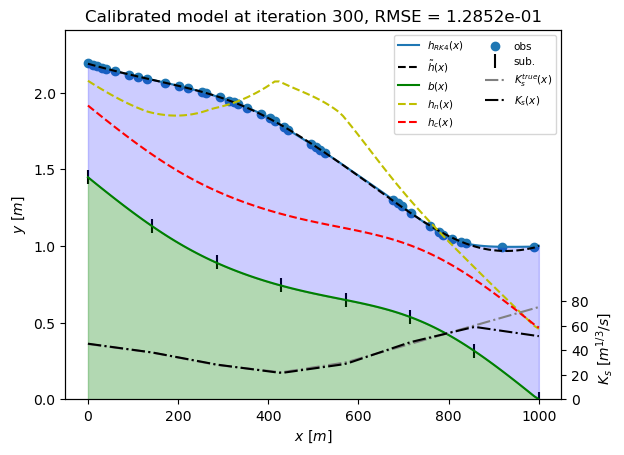

In [217]:
model.train_model(J, col, obs, ref_solution, 
                  normalize_J = True, #Choose whether you want to normalize J by J_0 or not
                  pre_train_iter = 100, #Choose the number of iterations for pre-training
                  alter_steps = 4, #Choose the number of alternating minimization steps
                  alter_freq = (40, 10), #Choose the number of iterations on theta (first value) and on k (second value) for each step
                  display_freq = (50, 100)) #Choose the display frequency for the training informations (first value) and the results plot (second value)

# Display training and results

##################################################
Final parameter RMSE : 5.06e-02
Final variable RMSE : 7.70e-03
##################################################


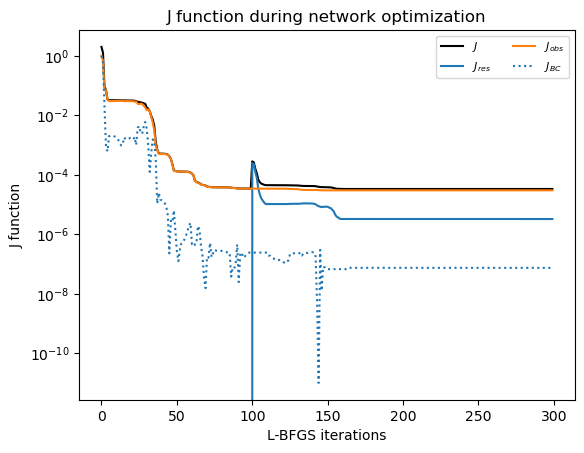

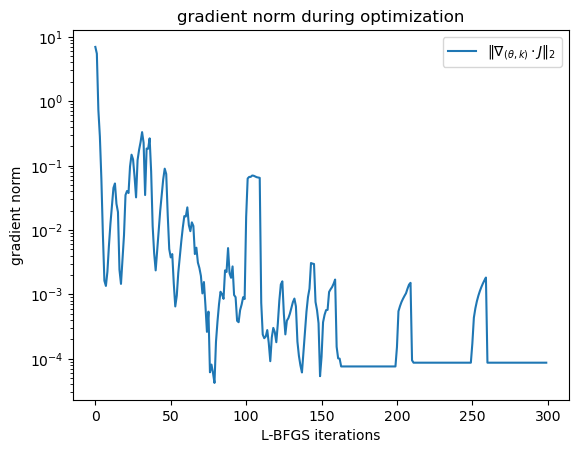

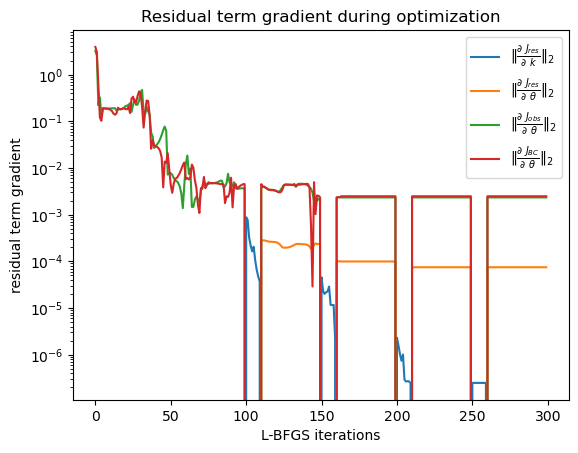

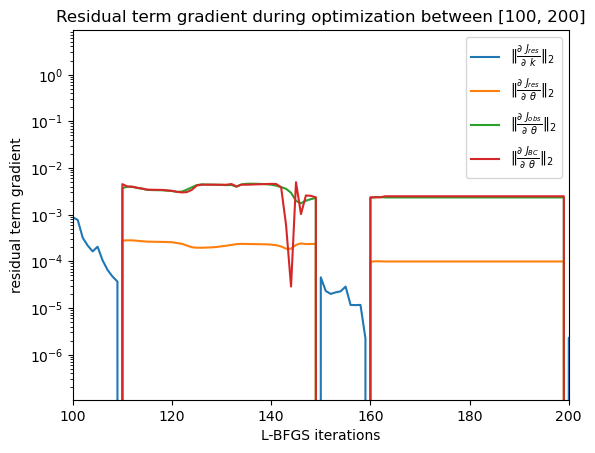

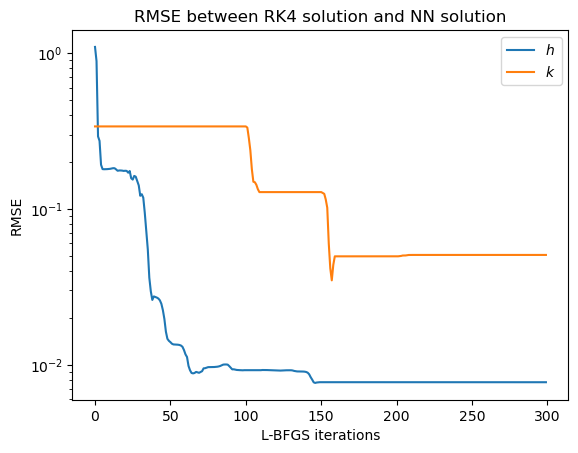

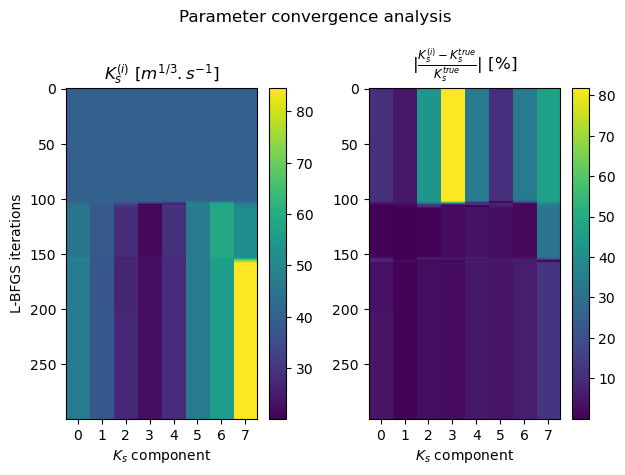

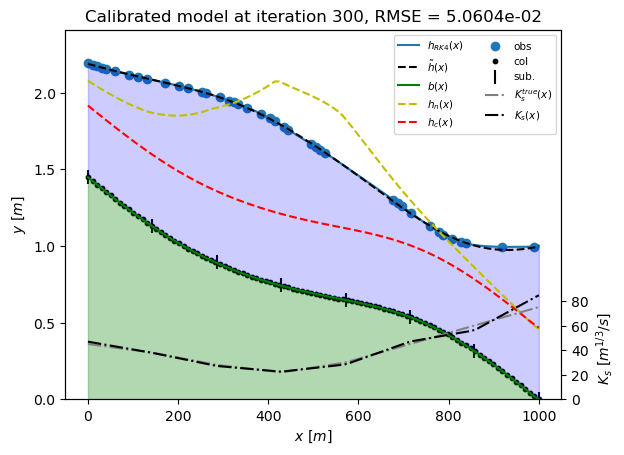

In [210]:
display.display_training(model, col, ref_solution)

display.display_results(model, col, ref_solution, obs, plot_col = True)